Following https://en.m.wikipedia.org/wiki/Karplus–Strong_string_synthesis


In [1]:
import numpy as np
import wave
import struct
import matplotlib.pyplot as plt
%matplotlib inline
import IPython
import scipy.interpolate as interp

In [2]:
sample_rate = 44100

def p(a):
    return IPython.display.Audio( a, rate=sample_rate, autoplay = True )

OK so now we can try and make a simple synth using the delay line and the shift-by-one filter.
Initializing with noise this makes a plucked string type sound.

In [3]:
def kp_standalone():
    freq = 220
    # F = sample / ( N + .5 )
    # so N + .5 = sample / F

    burstlen = int( (sample_rate / freq + 0.5)* 2 )

    samplelen = sample_rate * 3
    result = np.zeros( samplelen )
    noise = np.random.rand( burstlen ) * 2 - 1

    result[0:burstlen] = noise
    delay = noise

    pos = burstlen
    
    filtAtten = 0.4;
    filtWeight = 0.5

    filtAtten = filtAtten / 100  / ( freq / 440 )

    while( pos < samplelen ):
        dpos = pos % burstlen
        dpnext = (pos + 1 ) % burstlen
        dpfill = (pos - 1) % burstlen

        # Simple averaging filter
        filtval = ( filtWeight * delay[ dpos ] + (1.0 - filtWeight ) * delay[ dpnext ] )  * (1.0 - filtAtten)

        result[ pos ] = filtval
        delay[ dpfill ] = filtval
    
        pos = pos + 1

    return result
        
p( kp_standalone() )
# filtAtten


Great! So from that method we want to do a few things

* Make it feel more like a "class" with a step operator
* Change the seed (not just noise; also square saw and chirp)
* Change the filter styles (3 point; comb)
* Handle frequency shifts and stuff while going
* Have non-integral frequencies and interpolate appropriately (do this one last with
an internal buffer we interpolate)

So lets get to work on that!

In [7]:
class KSSynth:
    def __init__(self):
        self.pos = 0
        self.filtWeight = 0.5
        self.filtAtten = 3.0
        
        self.filterType = "weightedOneSample"
        
        self.setFreq( 220 )
        
        self.initPacket = "random"
        
    def setFreq( self, freq ):
        self.freq = freq
        self.burstlen = int( ( sample_rate / freq + 0.5 ) * 2 )
        self.filtAttenScaled = self.filtAtten / 100 / ( self.freq / 440 )
        
    def trigger( self, freq ):
        self.setFreq( freq )
        self.delay = []
        ls = np.linspace( 0, self.burstlen-1, self.burstlen ) / self.burstlen
        if( self.initPacket == "random" ):
            self.delay = np.random.rand( self.burstlen ) * 2 - 1   
        if( self.initPacket == "square" ):
            mp = int(self.burstlen/2)
            self.delay = np.zeros( self.burstlen )
            self.delay[ :mp ] = 1
            self.delay[ mp: ] = -1
        if( self.initPacket == "saw" ):
            self.delay = ls * 2 - 1
        if( self.initPacket == "noisysaw" ):
            self.delay = ls  * 1 - 0.5 + np.random.rand( self.burstlen ) - 0.5
        if( self.initPacket == "sin" ):
            self.delay = np.sin( ls  * 2 * np.pi )
        if( self.initPacket == "sinChirp" ):
            lse = np.exp( ls * 2 ) * 3
            self.delay = np.sin( lse * 2 * np.pi )
        if( len( self.delay ) == 0 ):
            print( "Didn't grok ", self.initPacket )
        
    def adjFrequency( self, freq ):
        """This is different than trigger in that it keeps current waves and interps them to a new freq"""
        oldbl = self.burstlen
        olddel = self.delay
        self.setFreq( freq )
        
        olddi = interp.interp1d( np.arange( 0, oldbl ), olddel )
        newy = np.arange( 0, self.burstlen ) * (oldbl-1) / (self.burstlen-1)
        self.delay = olddi( newy )
        
    def step( self ):
        dpos = self.pos % self.burstlen
        dpnext = ( self.pos + 1 ) % self.burstlen
        dpfill = ( self.pos - 1 ) % self.burstlen

        # Simple averaging filter
        fw = self.filtWeight;
        fa = self.filtAttenScaled;
        filtval = -1000;
        if( self.filterType == "weightedOneSample" ):
            filtval = ( fw * self.delay[ dpos ] + ( 1.0 - fw ) * self.delay[ dpnext ] )  * ( 1.0 - fa )
        if( filtval == -1000 ):
            filtval = 0
            print( "Filtval misset ", self.filterType )
            
        self.delay[ dpfill ] = filtval
    
        self.pos = self.pos + 1      
        return filtval


In [22]:
k = KSSynth()
k.trigger( 440 )
# print( np.average( k.delay ) )
print( np.sqrt( np.sum( [ i * i for i in k.delay ])) / k.burstlen )
[k.step() for i in range( 2000 )]
# print( np.average( k.delay ) )
print( np.sqrt( np.sum( [ i * i for i in k.delay ])) / k.burstlen )
[k.step() for i in range( 2000 )]
# print( np.average( k.delay ) )
print( np.sqrt( np.sum( [ i * i for i in k.delay ])) / k.burstlen )



#ds = [ k.step() for i in range(sample_rate)]
#print( k.filtAttenScaled, " ", k.burstlen )
p(ds)
#plt.plot( ds )

0.04002992811679594
0.012173902763392348
0.007536444190202014


In [5]:
k = KSSynth()
packets = [ "random", "square", "saw", "noisysaw", "sin", "sinChirp" ]
npk = len( packets ) 
f = []
for i in range( 13 ):
    fm = pow( 2, i/12.0 ) 
    k.initPacket = packets[ i % npk ]
    k.trigger( fm * 220 )
    res = [ k.step() for i in range( int(sample_rate/2) ) ]
    f = f + res
    
p( f )

In [6]:
k = KSSynth();
f = []
k.filtAtten = 0.1
fr = 440;
k.trigger( 440 )
sr10 = int( sample_rate / 500 )
mul = 1.005
for i in range( 800 ):
    res = [ k.step() for i in range( sr10 )]
    fr = fr * mul
    k.adjFrequency( fr )
    f = f + res
    if( i == 250 ):
        #fr = 440
        mul = 0.999
p( f )

In [7]:
np.linspace( 0, 70, 71 )

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70.])

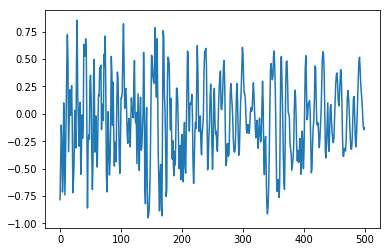

In [8]:
plt.plot( f[ 0:500 ] )